In [5]:
!pip install researchpy

pexpect 4.6.0 requires ptyprocess>=0.5, which is not installed.
You are using pip version 10.0.1, however version 19.2.3 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


In [54]:
import sqlite3 
import pandas as pd
import numpy as np
import math 

from datetime import datetime

from scipy import stats
from scipy.stats import ttest_ind

from statsmodels.formula.api import ols
import statsmodels.api as sm
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.multicomp import MultiComparison
from statsmodels.stats.power import TTestIndPower, TTestPower

import researchpy as rp

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_palette('colorblind')

import warnings
warnings.filterwarnings("ignore")

In [10]:
conn = sqlite3.connect('Northwind_small.sqlite')
c = conn.cursor()

Discount vs. No Discount

In [11]:
c.execute("""SELECT Quantity, Discount 
               FROM OrderDetail
               ORDER BY ProductId;""")
df = pd.DataFrame(c.fetchall())
df.columns = [x[0] for x in c.description]
df.head()

,Quantity,Discount
0,45,0.20
1,18,0.00
2,20,0.00
3,15,0.15
4,12,0.00


In [12]:
df['Discount'].value_counts()

0.00    1317
0.05     185
0.10     173
0.20     161
0.15     157
0.25     154
0.03       3
0.02       2
0.01       1
0.04       1
0.06       1
Name: Discount, dtype: int64

In [13]:
drop = [0.01, 0.02, 0.03, 0.04, 0.06]
df = df[~df['Discount'].isin(drop)]

In [14]:
df['Discount'].value_counts()

0.00    1317
0.05     185
0.10     173
0.20     161
0.15     157
0.25     154
Name: Discount, dtype: int64

In [15]:
no_discount = df.loc[df['Discount'] == 0, 'Quantity']
no_discount.head()

1    18
2    20
4    12
6    10
7    24
Name: Quantity, dtype: int64

In [22]:
discount = df.loc[df['Discount'] != 0, 'Quantity']
discount.head()

0     45
3     15
5     15
9     40
10     8
Name: Quantity, dtype: int64

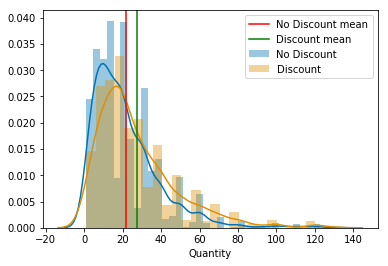

In [23]:
sns.distplot(no_discount, label='No Discount')
sns.distplot(discount, label='Discount')
plt.axvline(np.mean(no_discount), color='#FF0000', label=('No Discount mean:', np.mean(no_discount))
plt.axvline(np.mean(discount), color='#008000', label=('Discount mean:', np.mean(discount))
plt.legend()
plt.show();

In [24]:
no_discount_mean = np.mean(no_discount)
discount_mean = np.mean(discount)
mean_difference = discount_mean - no_discount_mean
round(discount_mean,2), round(no_discount_mean,2), round(mean_difference,2)

(27.35, 21.72, 5.64)

In [25]:
alpha = 0.05

Testing for Normality

In [50]:
stats.shapiro(discount)

(0.8673426508903503, 6.471277454941499e-26)

In [51]:
stats.shapiro(no_discount)

(0.8434571027755737, 3.803856556577728e-34)

Testing for Homogeneity of Variance

In [26]:
# perform Bartlett test for variance
stats.bartlett(discount, no_discount)

BartlettResult(statistic=29.48129316230489, pvalue=5.645902482998379e-08)

In [28]:
# perform Levene test for homogeneity of variance
stats.levene(discount, no_discount)

LeveneResult(statistic=14.296405109976126, pvalue=0.0001604308631855048)

In [29]:
#welch's t done in researchpy 
#equal_variance = False to perform Welch's T Test
descriptives, results = researchpy.ttest(discount, no_discount, equal_variance = False)
descriptives

,Variable,N,Mean,SD,SE,95% Conf.,Interval
0,Quantity,830.0,27.354217,20.720667,0.719225,25.942501,28.765933
1,Quantity,1317.0,21.715262,17.507493,0.482426,20.768853,22.661671
2,combined,2147.0,23.895203,19.009580,0.410257,23.090659,24.699746


In [ ]:
results

In [30]:
#t-critical value 
print ('t-critical value:',stats.t.ppf(1 - 0.05, df=1561))

t-critical value: 1.6458303594014525


Level of Discount

In [31]:
disc_00 = df.loc[df['Discount'] == 0.00, 'Quantity']
disc_05 = df.loc[df['Discount'] == 0.05, 'Quantity']
disc_10 = df.loc[df['Discount'] == 0.10, 'Quantity']
disc_15 = df.loc[df['Discount'] == 0.15, 'Quantity']
disc_20 = df.loc[df['Discount'] == 0.20, 'Quantity']
disc_25 = df.loc[df['Discount'] == 0.25, 'Quantity']

In [32]:
all_discounts = [disc_05, disc_10, disc_15, disc_20, disc_25]

In [37]:
for disc in all_discounts:
    parameters, results = rp.ttest(disc, disc_00, equal_variances=False)
    results

In [38]:
stats.f_oneway(disc_05, disc_10, disc_15, disc_20, disc_25)

F_onewayResult(statistic=0.6741032559876161, pvalue=0.610041445360832)

In [39]:
print ('f-critical value:',stats.f.cdf(1-0.05, dfn=3, dfd=1561))

f-critical value: 0.5843916553857266


In [ ]:
mc = MultiComparison(df['Quantity'], df['Discount'])
mc_results = mc.tukeyhsd()

In [ ]:
mc_results.plot_simultaneous(comparison_name=0.0, figsize=(6,4), 
                             ylabel='Discount Level\n', xlabel='\nAverage Number of Products in Order');

In [40]:
power = TTestIndPower()
power_05 = power.power(effect_size=0.3948744653331997, nobs1=len(disc_05), alpha=alpha, ratio=len(no_discount)/len(disc_05), df=(len(disc_05) -1 + len(no_discount)-1), alternative='larger')
power_10 = power.power(effect_size=0.19821666416305028, nobs1=len(disc_10), alpha=alpha, ratio=len(no_discount)/len(disc_10), df=(len(disc_10) -1 + len(no_discount)-1), alternative='larger')
power_15 = power.power(effect_size=0.45301566498890056, nobs1=len(disc_15), alpha=alpha, ratio=len(no_discount)/len(disc_15), df=(len(disc_15) -1 + len(no_discount)-1), alternative='larger')
power_20 = power.power(effect_size=0.3750987110329681, nobs1=len(disc_20), alpha=alpha, ratio=len(no_discount)/len(disc_20), df=(len(disc_20) -1 + len(no_discount)-1), alternative='larger')
power_25 = power.power(effect_size=0.4109384470929913, nobs1=len(disc_25), alpha=alpha, ratio=len(no_discount)/len(disc_25), df=(len(disc_25) -1 + len(no_discount)-1), alternative='larger')

In [41]:
power_05, power_10, power_15, power_20, power_25

(0.9996403433653781,
 0.7896313760530537,
 0.9999999596290499,
 0.9977853833217225,
 0.9992590585768565)

Order Total and Discount

In [53]:
c.execute("""SELECT [Order].Id,
            Quantity*(OrderDetail.UnitPrice - (OrderDetail.UnitPrice*Discount))
               AS 'OrderTotal'
            FROM OrderDetail
            JOIN [Order]
            ON [Order].Id = OrderDetail.OrderId
            INNER JOIN Product
            ON Product.Id = OrderDetail.ProductId
            WHERE Discount != 0.06 AND Discount > 0.04 OR Discount = 0.00
            GROUP BY [Order].Id
             ;""")
df = pd.DataFrame(c.fetchall())
df.columns = [x[0] for x in c.description]
df.head()

,Id,Discount,UnitPrice,Quantity
0,10248,0.0,14.0,12
1,10248,0.0,9.8,10
2,10248,0.0,34.8,5
3,10249,0.0,18.6,9
4,10249,0.0,42.4,40


In [1]:
df['Total']= df['UnitPrice']* df['Quantity']
df = df.groupby(['OrderId']).sum().head()

NameError: name 'df' is not defined

In [ ]:
not_discounted = df.loc[df['Discount'] == 0, 'OrderTotal']
not_discounted.head()

In [ ]:
discounted = df.loc[df['Discount'] != 0, 'OrderTotal']
discounted.head()

In [ ]:
descriptives, results = rp.ttest(discounted, not_discounted, equal_variances = False)
descriptives

Customer Loyalty

$H_0$: People who order more frequently (= above the median) do not spend more money on average than people who order less frequently.

$H_1$: People who order more frequently also spend more money on average than people who order less frequently.

In [ ]:
c.execute('''SELECT Customer.Id, [Order].Id,
                           Quantity*(OrderDetail.UnitPrice - (OrderDetail.UnitPrice*Discount))
                            AS 'OrderTotal'
                            FROM OrderDetail
                            JOIN [Order] ON OrderDetails.OrderId = [Order].Id
                            JOIN Customer ON [Order].CustomerId = Customer.Id
                            GROUP BY CustomerId
                           ORDER BY SUM(OrderTotal) DESC
                            ;''')
df = pd.DataFrame(c.fetchall())
df.columns = [x[0] for x in c.description]
df.head()

In [ ]:
mean = np.mean(df['OrderId'].count())
median = np.median(df['OrderId'].count())
print('Mean:', mean)
print('Median:', median)

In [ ]:
df['Number of Orders'] = df['OrderId'].count().apply(lambda x: 'Below Median' if x <= median else 'Above Median')
df.head()

In [ ]:
frequent = df.loc[df['Number of Orders'] == 'Above Median']
regular = df.loc[df['Number of Orders'] == 'Below Median']

In [ ]:
stats.levene(frequent, regular)

Shipping Speed

In [57]:
c.execute("""SELECT ShippedDate, ShipVia, OrderDate, RequiredDate
            FROM 'Order'
             ;""")
df = pd.DataFrame(c.fetchall())
df.columns = [x[0] for x in c.description]
df.head()

,ShippedDate,ShipVia,OrderDate,RequiredDate
0,2012-07-16,3,2012-07-04,2012-08-01
1,2012-07-10,1,2012-07-05,2012-08-16
2,2012-07-12,2,2012-07-08,2012-08-05
3,2012-07-15,1,2012-07-08,2012-08-05
4,2012-07-11,2,2012-07-09,2012-08-06


In [58]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 830 entries, 0 to 829
Data columns (total 4 columns):
ShippedDate     809 non-null object
ShipVia         830 non-null int64
OrderDate       830 non-null object
RequiredDate    830 non-null object
dtypes: int64(1), object(3)
memory usage: 26.0+ KB


In [59]:
df = df.dropna()

In [60]:
df['ShippedDate']= pd.to_datetime(df['ShippedDate'])
df['OrderDate'] = pd.to_datetime(df['OrderDate'])
df['RequiredDate'] = pd.to_datetime(df['RequiredDate'])

In [62]:
df['ShipTime'] = (df['ShippedDate'] - df['OrderDate']).dt.days

In [63]:
df.groupby(['ShipVia'])['ShipTime'].mean()

ShipVia
1    8.571429
2    9.234921
3    7.473896
Name: ShipTime, dtype: float64

In [65]:
descriptives, results = rp.ttest(df['ShipTime'], df['ShipVia'], equal_variances = False)
descriptives

,Variable,N,Mean,SD,SE,95% Conf.,Interval
0,ShipTime,809.0,8.491965,6.838682,0.240435,8.020014,8.963917
1,ShipVia,809.0,2.004944,0.781896,0.027490,1.950984,2.058905
2,combined,1618.0,5.248455,5.848220,0.145390,4.963282,5.533627


In [64]:
#anova
stats.f_oneway(df['ShipTime'], df['ShipVia'])

F_onewayResult(statistic=718.5448047260277, pvalue=2.9251787431230465e-131)

Employee Sales

In [70]:
c.execute("""SELECT EmployeeId
               ,FirstName || ' ' || LastName
               AS 'Name', 
               Quantity*(OrderDetail.UnitPrice - (OrderDetail.UnitPrice*Discount))
               AS 'OrderTotal'
               FROM [Order]
               LEFT OUTER JOIN Employee
               ON [Order].EmployeeId=Employee.Id
               LEFT OUTER JOIN OrderDetail
               ON [Order].Id=OrderDetail.OrderId
               GROUP BY EmployeeId
               ORDER BY SUM(OrderTotal) DESC;""")
df = pd.DataFrame(c.fetchall())
df.columns = [x[0] for x in c.description]
df.head()

,EmployeeId,Name,Region,OrderTotal,Discount
0,6,Michael Suyama,British Isles,1272.000,0.00
1,9,Anne Dodsworth,British Isles,714.000,0.00
2,3,Janet Leverling,North America,662.400,0.10
3,4,Margaret Peacock,North America,375.000,0.25
4,7,Robert King,British Isles,232.085,0.05


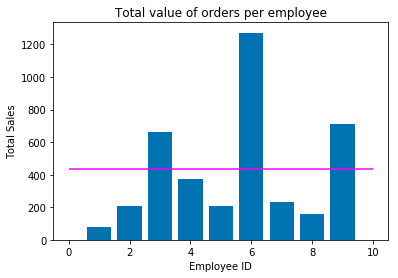

In [79]:
plt.bar(df['EmployeeId'], df['OrderTotal'])
plt.hlines(y=df["OrderTotal"].mean(), xmin=0, xmax=10, color='magenta')

plt.title('Total value of orders per employee')
plt.xlabel('Employee ID')
plt.ylabel('Total Sales')

plt.show()